# Goal 

The goal of this notebook is to predict the houses prices and figure out what is the best model to do that. 

Most of the functions used in this notebook are in the daftmodel.py module.

# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer, get_weigts, plot_metrics)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load Data

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

**Clusters**

As indicated in the notebook Clustering_Real_Estate_Data the below data have been used to try to improve the performance of the algorithms. However, the results were a little bit worse so it has been quited (raw cells). The mean absolute errors with the cluster variable are show bellow as well, just for comparation.

![]()

**Predictors**

Below you can see the predictors that I will use.

In [6]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
# Remove cluster column to not apply transformation to it
num_features.remove('cluster')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [7]:
levels_type_house = data.type_house.unique()
levels_place = data.place.unique()
# levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [levels_place, levels_type_house] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,place,"[nan, Naas, Wexford, Dublin 8, Dublin 6W, Carr...","[nan, Naas, Wexford, Dublin 8, Dublin 6W]"
1,type_house,"[house, nan, apartment]","[house, nan, apartment]"


## Split Data

In [8]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place',
    'cluster']

data = data[features].copy()
data.shape

(7344, 9)

In [9]:
# Mean prices to build the base model
mean_prices = data.groupby('place')[['price','place']].mean().sort_values('price', ascending=False)
mean_prices.head(3)

,price
place,
Dublin 6,1.047290e+06
Dun Laoghaire,8.952080e+05
Dublin 4,8.143643e+05


The `split_data()` function lets us spliting the data in several ways if I wish.

In [10]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 8) 
X_test: (1102, 8) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

I will use the following metrics to evaluate the models:

In [11]:
# It will be used in the `scores_statistics()` function
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Missing Values Treatment And Transformations

# Models

## Baseline Model

In [12]:
def get_base_predictions(mean_prices, data_to_predict):

    mean_price = mean_prices.mean()
    # print(mean_price.values[0])
    y_pred = data_to_predict.merge(mean_prices, how='left', left_on='place', right_index=True).price
    y_pred.fillna(value=mean_price.values[0], inplace=True)
    
    return y_pred

In [13]:
print('Performance on the training set:\n', '-'*10)
y_pred_train = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

metrics_to_plot = {}
print('Performance on the test set:\n', '-'*10)
y_pred = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

# Add metrics to the dictionary to plot it 
metrics_to_plot['Baseline Model'] = metrics

Performance on the training set:
 ----------
R²: 0.3366146919030736
MAE: 157537.5281846715
MAPE: 0.5009050686059635
RMSE: 247639.9117981296
R (corr): 0.581197357024071

Performance on the test set:
 ----------
R²: 0.23766197391151822
MAE: 149689.27015807052
MAPE: 0.5023062442705521
RMSE: 222662.44453701816
R (corr): 0.5102568176397978



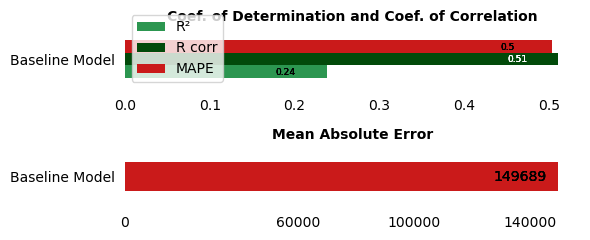

In [14]:
plot_metrics(metrics_to_plot)

## Multiple Linear Regression

We are going to use the `transformer_estimator` function to encoder categorical variables, transform numerical variables and input the median to numerical variables and fill with `None` categorical ones with missing values.

Then we will use the `scores_statistics` function to plot the metrics after doing cross validation.

In [15]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                          levels_list=[levels_place, 
                                                       levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1, 
                                          num_feat=num_features,
                                          cat_feat=cat_features)

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.6389554406260465
r2 std: 0.012436844766045832 

MAE mean: -114331.51030045966
MAE std: 3284.5651362851095 

MAPE mean: -0.3631529345074401
MAPE std: 0.010870928326170214 

RMSE mean: -182357.53162577905
RMSE std: 12362.343809663485 



Above you can see the resulting metrics using cross validation. 

### Overfitting Analysis

Now I will check whether there is overfitting or not by calculating the metrics for the train and test sets. I will use the `metrics_regression` function to do that.

In [16]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Linear Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.6566254446453184
MAE: 111152.90642865427
MAPE: 0.3513752332026933
RMSE: 178164.74523512964
R (corr): 0.8103242836329899

Performance on the test set:
 ----------
R²: 0.6102840792654642
MAE: 106509.68029696333
MAPE: 0.35653732221872025
RMSE: 159201.53656243015
R (corr): 0.7896803467816411



Mean absolute error in the train set is only 5,000€ greater than in the test set so we can consider that there is not overfitting.

### Residuals Diagnostic

The `residuals` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

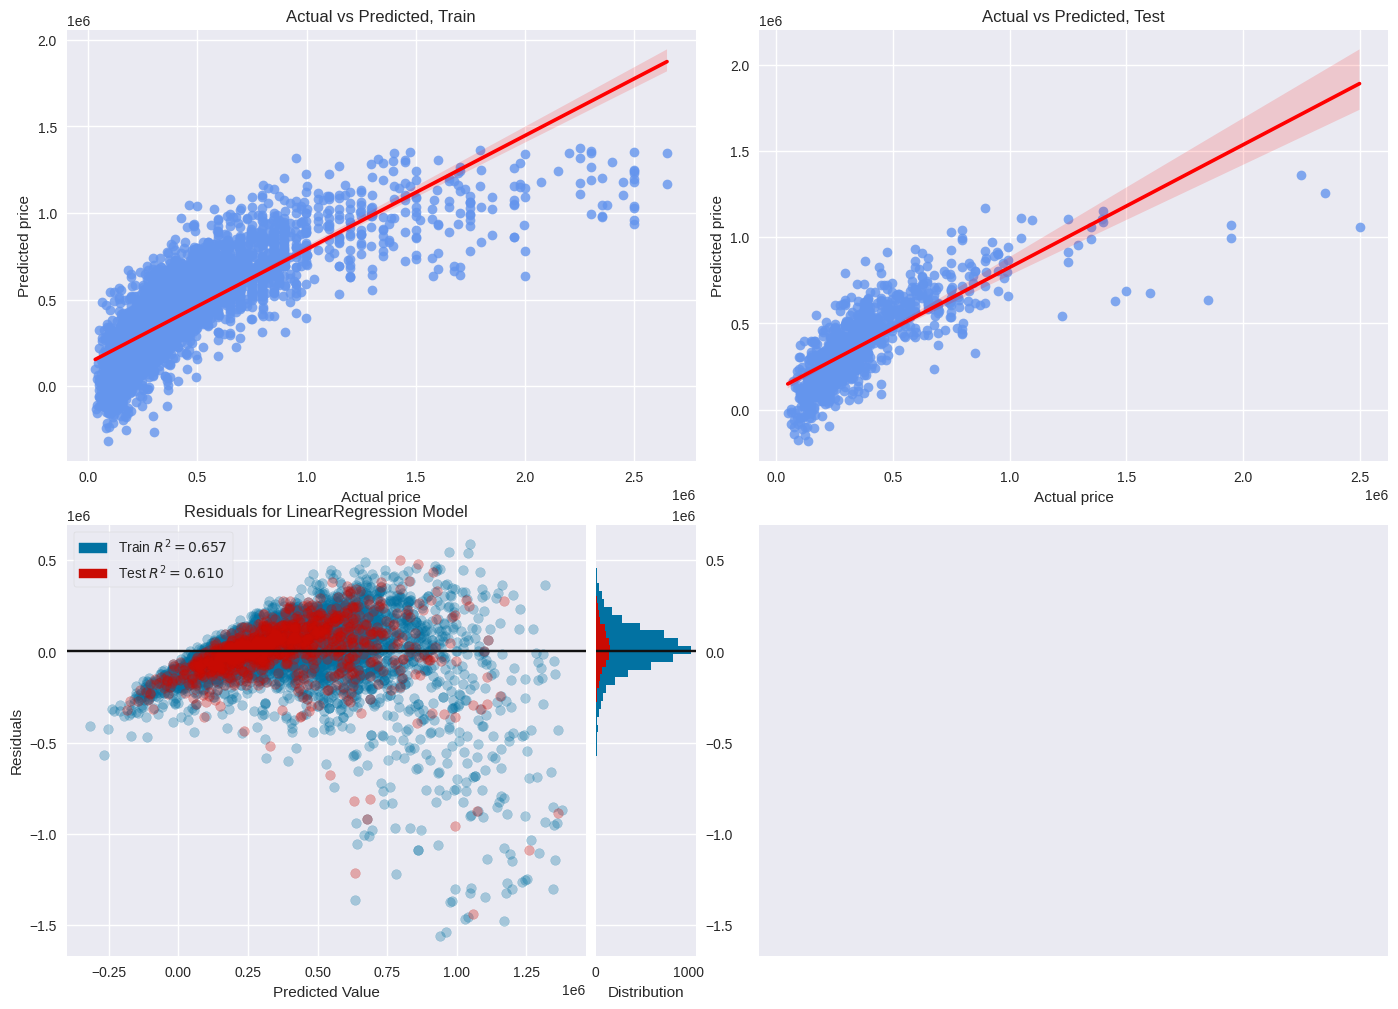

In [17]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

The residuals are calculated extracting `y_train` from `y_pred_train`: y_pred_train - y_train

- The model predices a few negative values, which is not possible in the real world.
- The model doesn't predice well the price of expensive houses. When a house is very expensive the model tends to understimate it.
- We can consider that there is not overfitting.

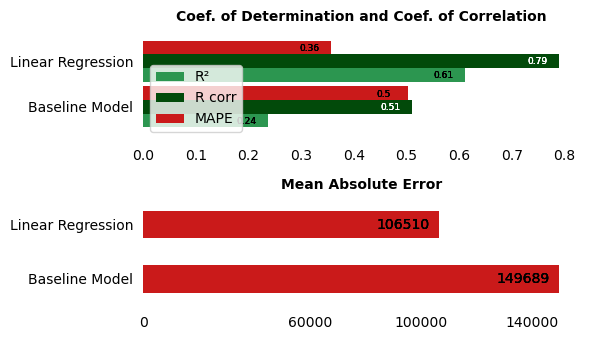

In [18]:
plot_metrics(metrics_to_plot)

## Polynomial Regression

First I will instance the GridSearchCV class and fit it to the training set to figure out the best hyperparameters. In this case I will try only different degrees to see what polinomial regression is the best.

In [19]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 8)}, 
                           cv=6, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 4}
0.7625031200277537


Once we have the best degree we use it to get an estimator and use it as a parameter to the function `scores_statistics`, as we did earlier. 

In [20]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=4,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=poly_pipe_estimator, 
                                          scoring_dict=scoring, 
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          cv=6, 
                                          return_train_score=False)

r2 mean: 0.7625036328416082
r2 std: 0.01551647485178258 

MAE mean: -92172.58797101252
MAE std: 2379.2291593332247 

MAPE mean: -0.26937266742422433
MAPE std: 0.013794483722365698 

RMSE mean: -147829.78711993946
RMSE std: 5640.171563046365 



There was an strange problem here. When `poly_degree` is 4 and `cv` is 5 the resulting metrics above have not sense, at least for me. You can try it by changing the `cv` value to 5. This only happens with the polynomial regression but also affects the voting regressors which contain it. Because of that I decided to use a `cv` of 6 in the polynomial regression and the voting regressor affected by that.

### Overfitting Analysis

In [21]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Polynomial Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.7975543379573422
MAE: 86325.91259317638
MAPE: 0.25055816743073855
RMSE: 136801.84473554353
R (corr): 0.8930589778717544

Performance on the test set:
 ----------
R²: 0.7594927075514359
MAE: 81273.27552396222
MAPE: 0.2537229345824688
RMSE: 125065.43721314368
R (corr): 0.8771869719879926



As we can see the polynomial regression with degree three perform better than a multiple linear regression.

### Residuals Diagnostic

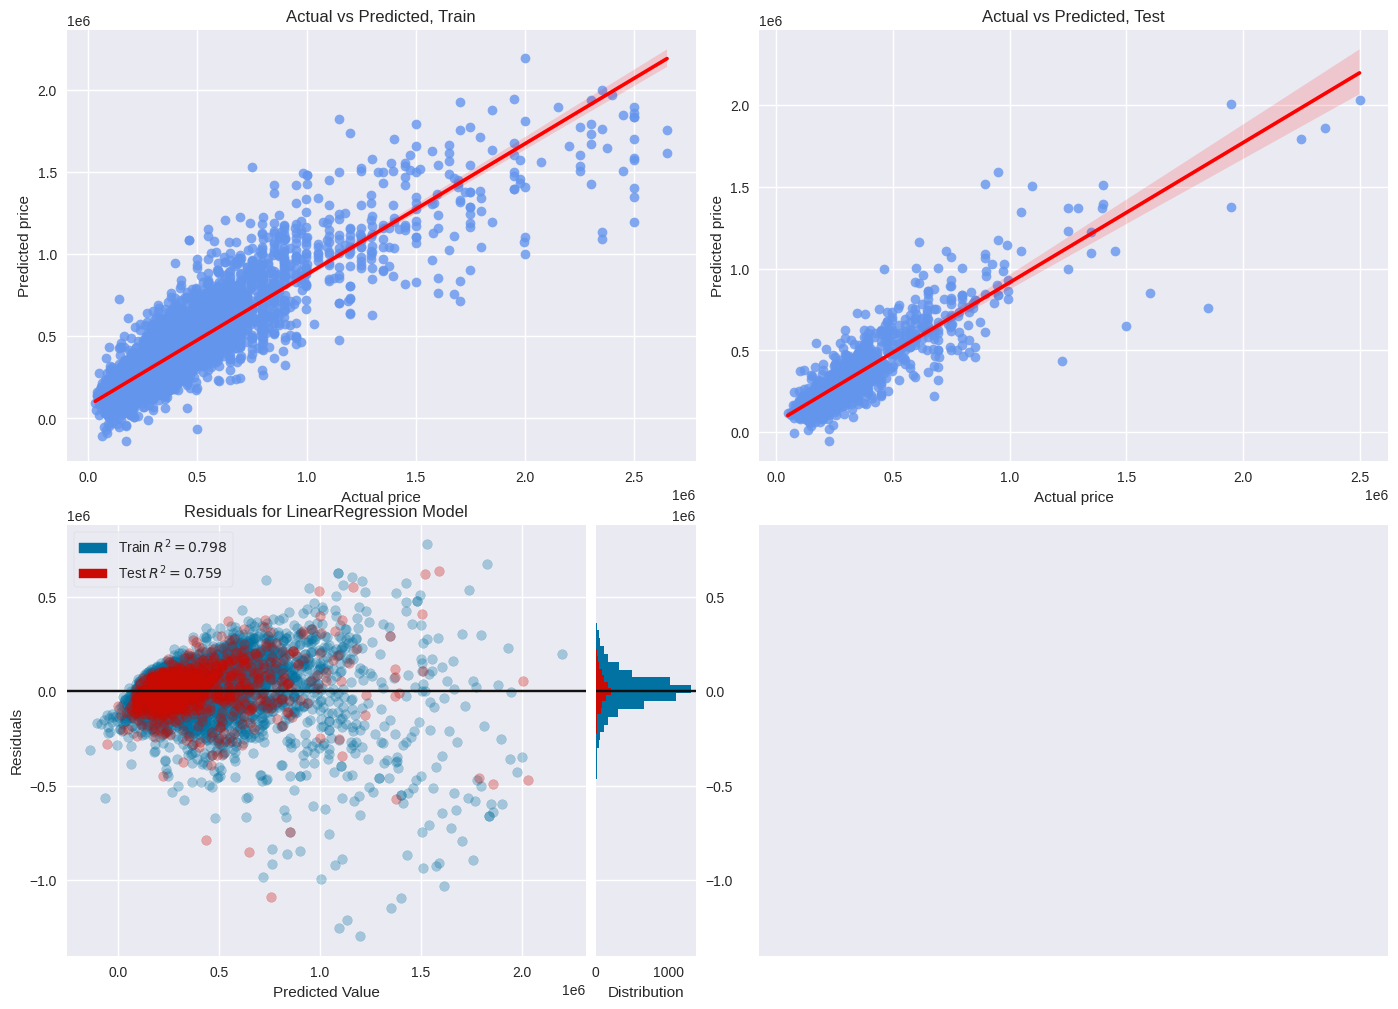

In [22]:
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

- The model still predices a few negative values.
- The model doesn't predice well the price of expensive houses. It also tends to understimate the value of expensive houses but is better than the linear regression.
- We can consider that there is not overfitting.

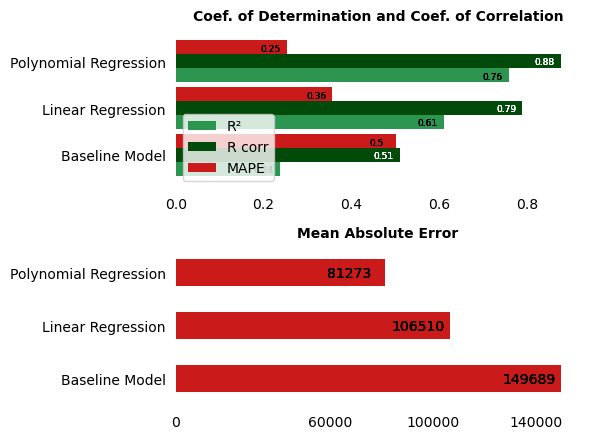

In [23]:
plot_metrics(metrics_to_plot)

## K Nearest Neighbors Regressor

In [24]:
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7512711119571973


In [25]:
# I use weights = 'uniform' instead of 'distance' to reduce overfitting
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', 
                                                                          leaf_size= 30), 
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=knnr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False, 
                                          return_est=True
                                         )

r2 mean: 0.7347223496210867
r2 std: 0.018062450526172356 

MAE mean: -90991.51386781587
MAE std: 2251.6106873786775 

MAPE mean: -0.24998729724657093
MAPE std: 0.008563536469404089 

RMSE mean: -156018.63759607094
RMSE std: 7884.324743180387 



### Overfitting Analysis

In [26]:
knnr = knnr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['K-Nearest Neighbors'] = metrics

Performance on the training set:
 ----------
R²: 0.8143393240141603
MAE: 76609.58117819381
MAPE: 0.21022798592197736
RMSE: 131007.95872869733
R (corr): 0.9027187363871525

Performance on the test set:
 ----------
R²: 0.7366414684269444
MAE: 79291.93984962405
MAPE: 0.22983411262033468
RMSE: 130872.04149247002
R (corr): 0.8587467908047972



The difference between performance in the training set is similar to the test set so it is okay in my opinion.

### Residuals Diagnostic

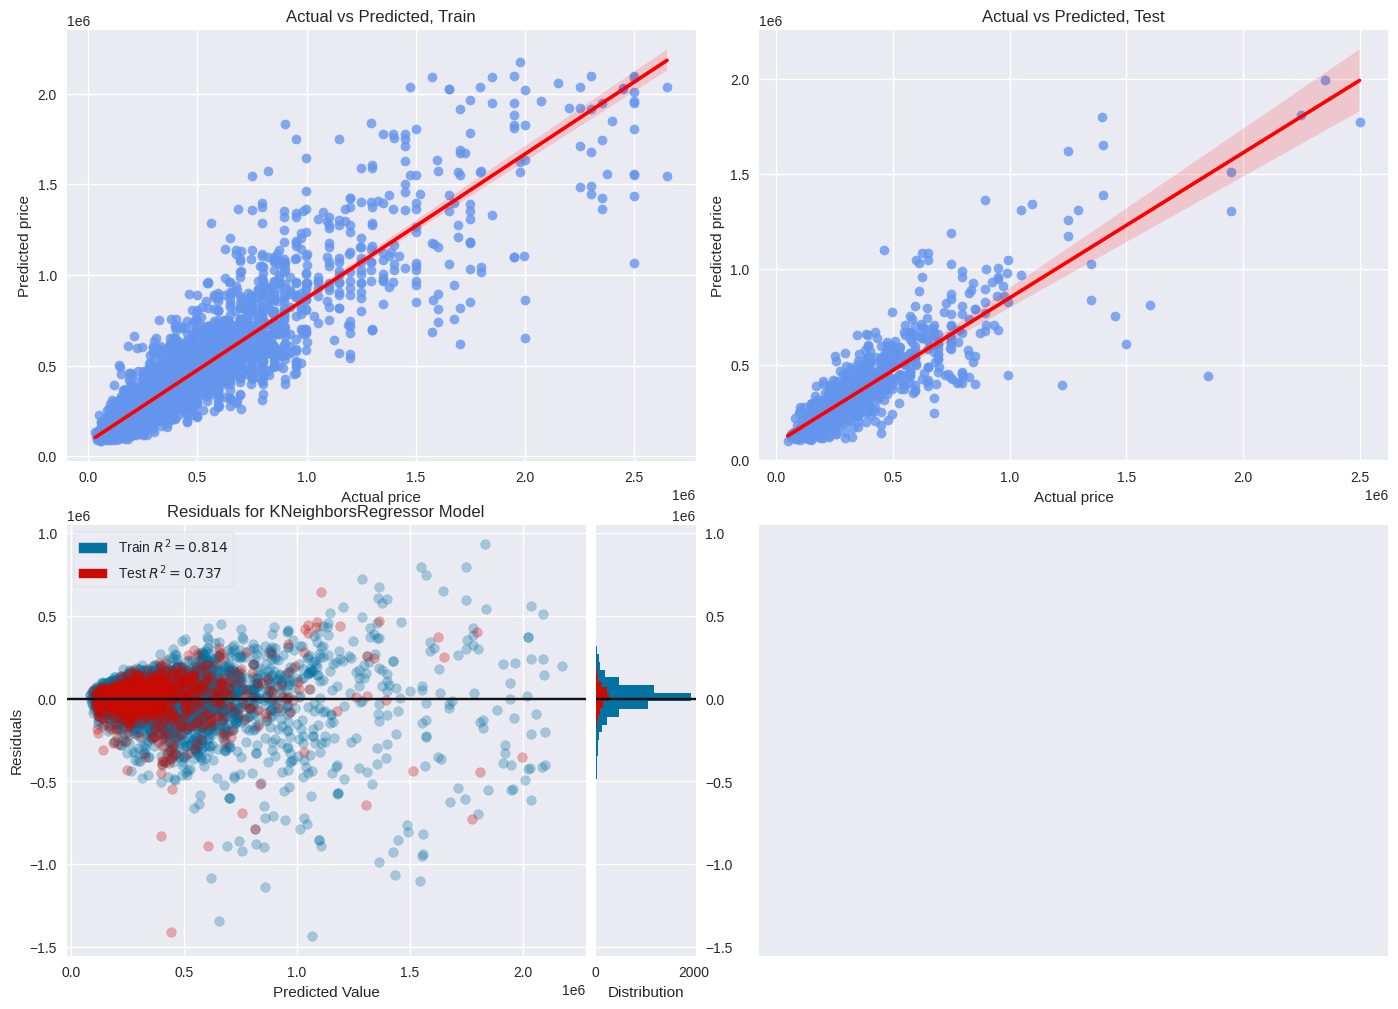

In [27]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

- This time we don't have negative values!
- The model is not very good predicing prices of houses with actual prices above a million, but there is no so clear tendency to understimate them as in the previous models, but there it is.
- There is a litle bit more overfitting than in the previous one but is not too much. It is okay in my opinion.

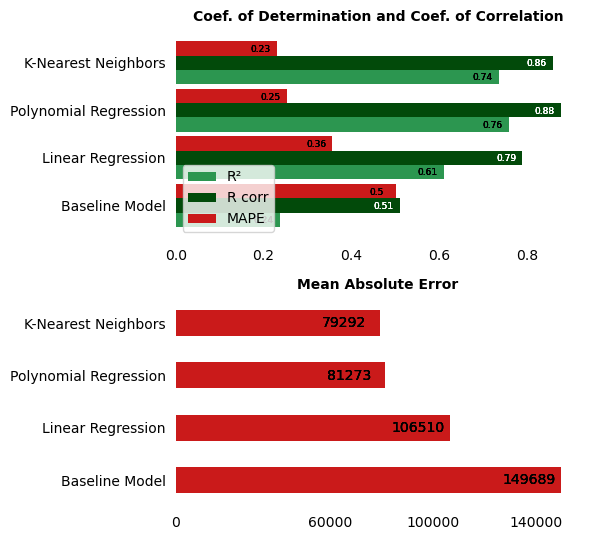

In [28]:
plot_metrics(metrics_to_plot)

## Decision Tree Regressor

In [29]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 12, 'regressor__min_samples_leaf': 20}
0.7419361708803778


In [30]:
#pd.DataFrame(grid_search.cv_results_)

In [31]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(max_depth=10,
                                                                           min_samples_leaf=30,  #16
                                                                       #   min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7241392413514912
r2 std: 0.016208061133650812 

MAE mean: -95800.9075161748
MAE std: 2992.7012437026597 

MAPE mean: -0.2714009639722631
MAPE std: 0.008651584917191734 

RMSE mean: -159240.01456669654
RMSE std: 9794.637556247415 



### Overfitting Analysis

In [32]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Decision Tree Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.7796071905921366
MAE: 83858.88782988206
MAPE: 0.23745635880920332
RMSE: 142736.95464148003
R (corr): 0.8829536740917592

Performance on the test set:
 ----------
R²: 0.7152036847576781
MAE: 83653.67766455417
MAPE: 0.2464408266449944
RMSE: 136094.43410211886
R (corr): 0.8484570979479041



In [33]:
# dtr

The different in MAE is insignificant so there is no overfitting. I have changed the parameter values to regularize a little the model as the different in the metrics was bigger earlier. That is why the parameters are different that the GridSearchCV ones.

### Residuals Diagnostic

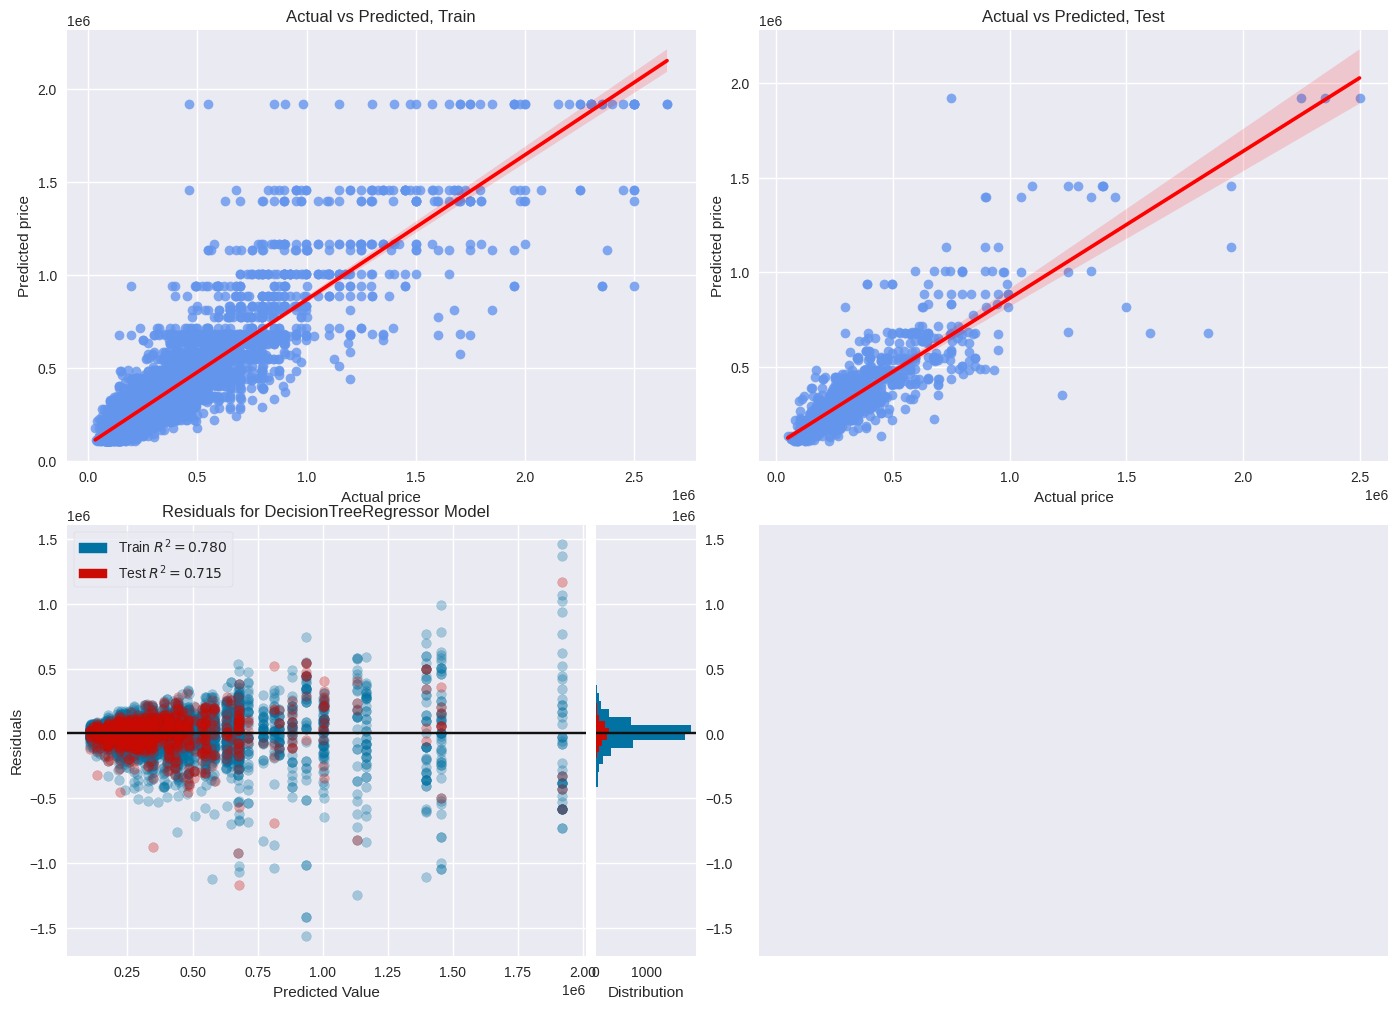

In [34]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

- The model appears to be pretty accurate in values less than 1 million € but the errors increase a lot as the actual price increases as well.
- There is a tendency to understimate values and it is clearer in houses with high values. 
- There is no overfitting.

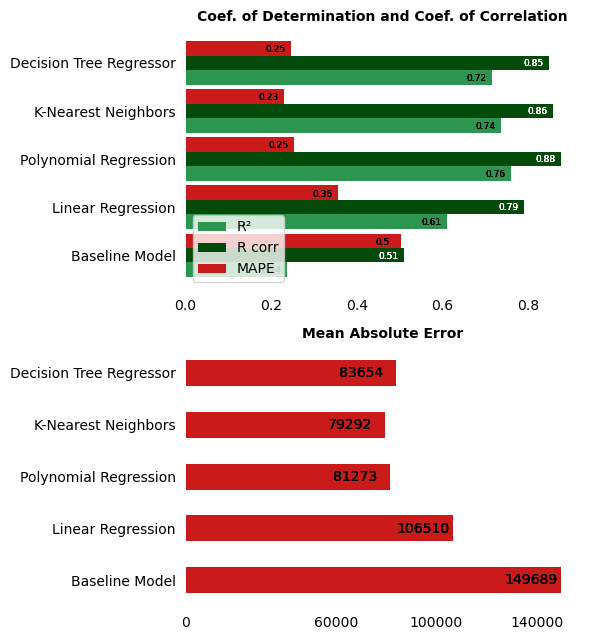

In [35]:
plot_metrics(metrics_to_plot)

## Voting Regressor with Basic Algorithms

I think it is interesting to investigate how the basic algorithms we used above can perform together. So let's do a voting regresor with them to figure out that.

In [36]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

Calculate the weights: we will use the performance in the test set to calculate the weights.

In [37]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['K-Nearest Neighbors'] = metrics_to_plot['K-Nearest Neighbors'][0]
scores_dict['Decision Tree Regressor'] = metrics_to_plot['Decision Tree Regressor'][0]


models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Polynomial Regression': 0.7594927075514359, 'K-Nearest Neighbors': 0.7366414684269444, 'Decision Tree Regressor': 0.7152036847576781}


In [38]:
polyr = poly_pipe_estimator
knnr = knnr_pipe_estimator
dtr = dtr_pipe_estimator


voting_regressor_BA = VotingRegressor(
    estimators = [('poly', polyr),
                  ('knn', knnr),
                  ('dt', dtr)], 
    weights = models_weigth_list)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
               'Voting Regressor': voting_regressor_BA}
# Comparing with corss validation
for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7625036328416082
MAE mean: -92172.58797101252
MAPE mean: -0.26937266742422433
RMSE mean: -147829.78711993946
----------
K Nearest Neighbors Regressor
r2 mean: 0.7343421255983543
MAE mean: -91193.05420181004
MAPE mean: -0.24993619516200496
RMSE mean: -156424.84102796068
----------
Decission Tree Regressor
r2 mean: 0.7206651940405759
MAE mean: -96633.34683969636
MAPE mean: -0.27208772282232013
RMSE mean: -160435.1301914593
----------
Voting Regressor
r2 mean: 0.7891714699200817
MAE mean: -82264.52162741704
MAPE mean: -0.2308000664270213
RMSE mean: -139393.83431089183
----------


Cool! We have been able to improve the performance with the voting regressor. Next we will do the overfitting analysisand the residuals diagnostic before start making more complex models. 

### Overfitting Analysis

In [39]:
voting_regressor_BA.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor_BA.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor_BA.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor BA'] = metrics

Performance on the training set:
 ----------
R²: 0.835490043941373
MAE: 72684.00498625767
MAPE: 0.20428870423501894
RMSE: 123320.08327539897
R (corr): 0.9155324938403119

Performance on the test set:
 ----------
R²: 0.7946238858783001
MAE: 71224.66324698247
MAPE: 0.2135346060030828
RMSE: 115570.80738221748
R (corr): 0.8915501821979135



The different in MAE is less than 2,000€ so we will consider there is no overfitting.

### Residuals Diagnostic

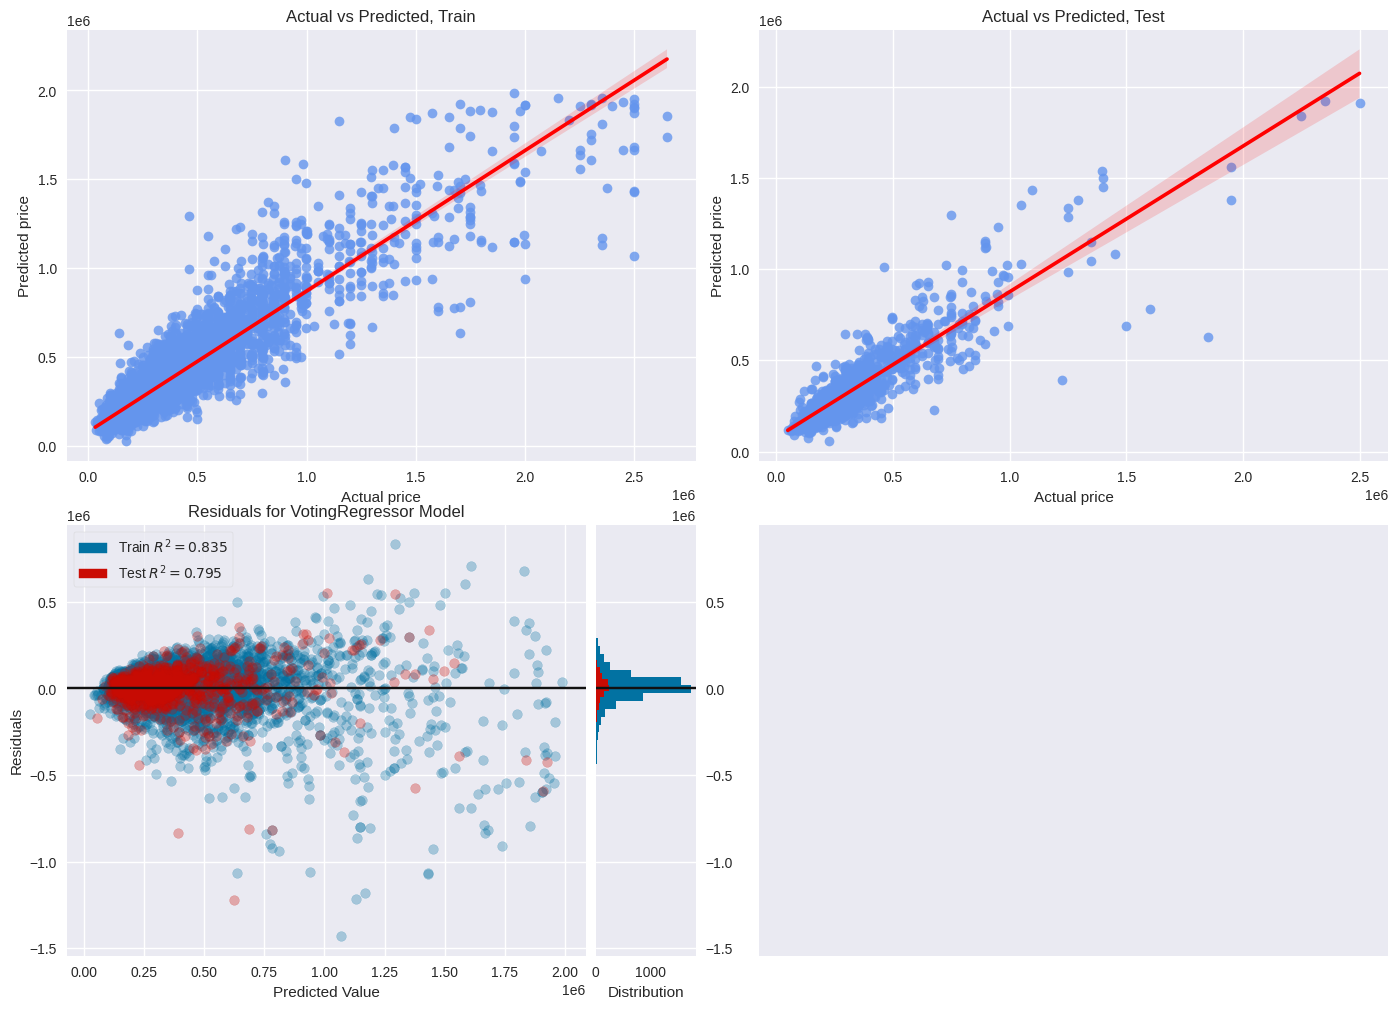

In [40]:
residuals(voting_regressor_BA, X_train, X_test, y_train, y_test)

- The voting regressor is clearly better than the models separately.  
- Once again we can realise that houses which actual price is higher than 1 million € are generally worst predicted than the other ones.
- There is a clear tendency to understimate prices as the actual prices increase. This is normal as the models that make up the voting regressor suffer the same condition.

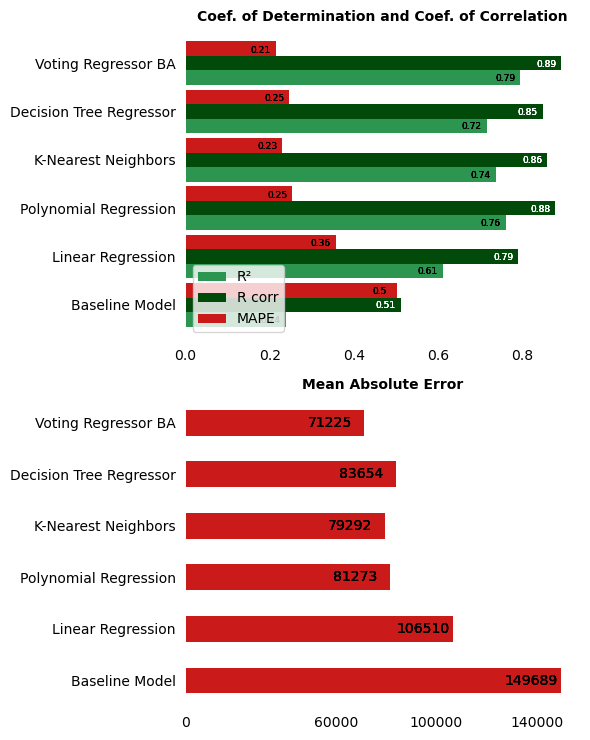

In [41]:
plot_metrics(metrics_to_plot)

## Random Forest Regressor

The random forest regressor cells have been runned iteratively several times in order to find the best combination of hyperparameters that maximize the performance while overfitting is under control.

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


Valor óptimo de n_estimators: 41


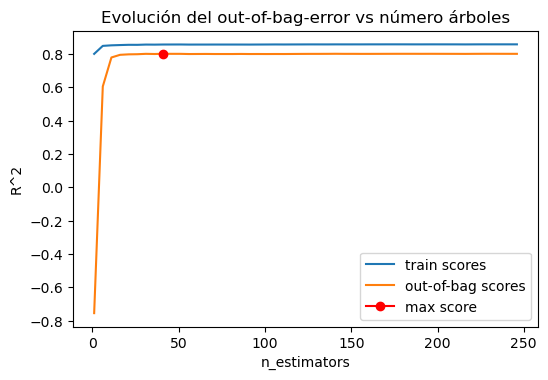

In [42]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 250, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    rfr = transformer_estimator(num_transformation='identity', 
                                regressor=RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=10,
                                    min_samples_leaf=9,  
                                    random_state=7,
                                    bootstrap=True,
                                    n_jobs=-1,
                                    oob_score = True
                                ), 
                                levels_list=[levels_place, levels_type_house],
                                poly_degree=1,
                                num_feat=num_features,
                                cat_feat=cat_features)

    
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    oob_scores.append(rfr.steps[-1][1].oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [43]:
from sklearn.model_selection import RandomizedSearchCV


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [41, 60, 100],
          #       'max_features': range(2, 20, 2), # ['log2', 'sqrt'],
                 'max_depth'   : [None, 3, 10, 20],
           #      'min_samples_split': [2, 5, 8, 15, 20, 43],  # 43
                 'min_samples_leaf': [1, 3, 5, 10, 20, 50],   #16
            #       'max_leaf_nodes': [2, 4, 8, 13, 20, 30, 40, 60, 80],   #68
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = transformer_estimator(num_transformation='identity', 
                                   regressor=RandomForestRegressor(
                              #         n_estimators=n_estimators,
                               #        max_depth=10,
                                #       min_samples_leaf=9,  
                                       random_state=7,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       oob_score = True, 
                                       ** params
                                   ), 
                                   levels_list=[levels_place, levels_type_house],
                                   poly_degree=1,
                                   num_feat=num_features,
                                   cat_feat=cat_features)
    
    

    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.steps[-1][1].oob_score_)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

,oob_r2,max_depth,min_samples_leaf,n_estimators
56,0.817694,20.0,1.0,100.0
2,0.817477,NaN,1.0,100.0
59,0.817395,20.0,3.0,100.0
5,0.817167,NaN,3.0,100.0


Despite the results obtained above if we are so little restrictive with the model and we allow it to have too many degrees of freedom the model will overffit the training data. So I have decided to restrict the model throught some hyperparameters in order to avoid it.

In [44]:
rfr = transformer_estimator(num_transformation='identity', 
                            regressor=RandomForestRegressor(
                                n_estimators=41,    #41
                                max_depth=10,
                                min_samples_leaf=9,  
                                random_state=7,
                                bootstrap=True,
                                n_jobs=-1,
                                oob_score = True 
                            ), 
                            levels_list=[levels_place, levels_type_house],
                            poly_degree=1,
                            num_feat=num_features,
                            cat_feat=cat_features)
    
rfr.fit(X_train, y_train)
print('Train score:', rfr.score(X_train, y_train))
print('Out-of-bag score', rfr.steps[-1][1].oob_score_)

Train score: 0.8575885770288723
Out-of-bag score 0.8022026758432338


#### As the other models

In [45]:
rfr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               max_depth=10,
                                               min_samples_leaf=9,  
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7946300899350615
r2 std: 0.0180508870529744 

MAE mean: -80514.09542697603
MAE std: 2943.095192423324 

MAPE mean: -0.23070889333440783
MAPE std: 0.007446596994958277 

RMSE mean: -137336.59477365436
RMSE std: 9715.18044597887 



In [46]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Random Forest Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.8586305633204291
MAE: 67357.75800329044
MAPE: 0.19759866549650984
RMSE: 114318.22690885852
R (corr): 0.9276471933192258

Performance on the test set:
 ----------
R²: 0.777221489668346
MAE: 71744.16284123682
MAPE: 0.21594170117051875
RMSE: 120367.66308912575
R (corr): 0.8830548851045031



The different between MAE is less than 5,000€ which is okay.

### Residuals Diagnostic

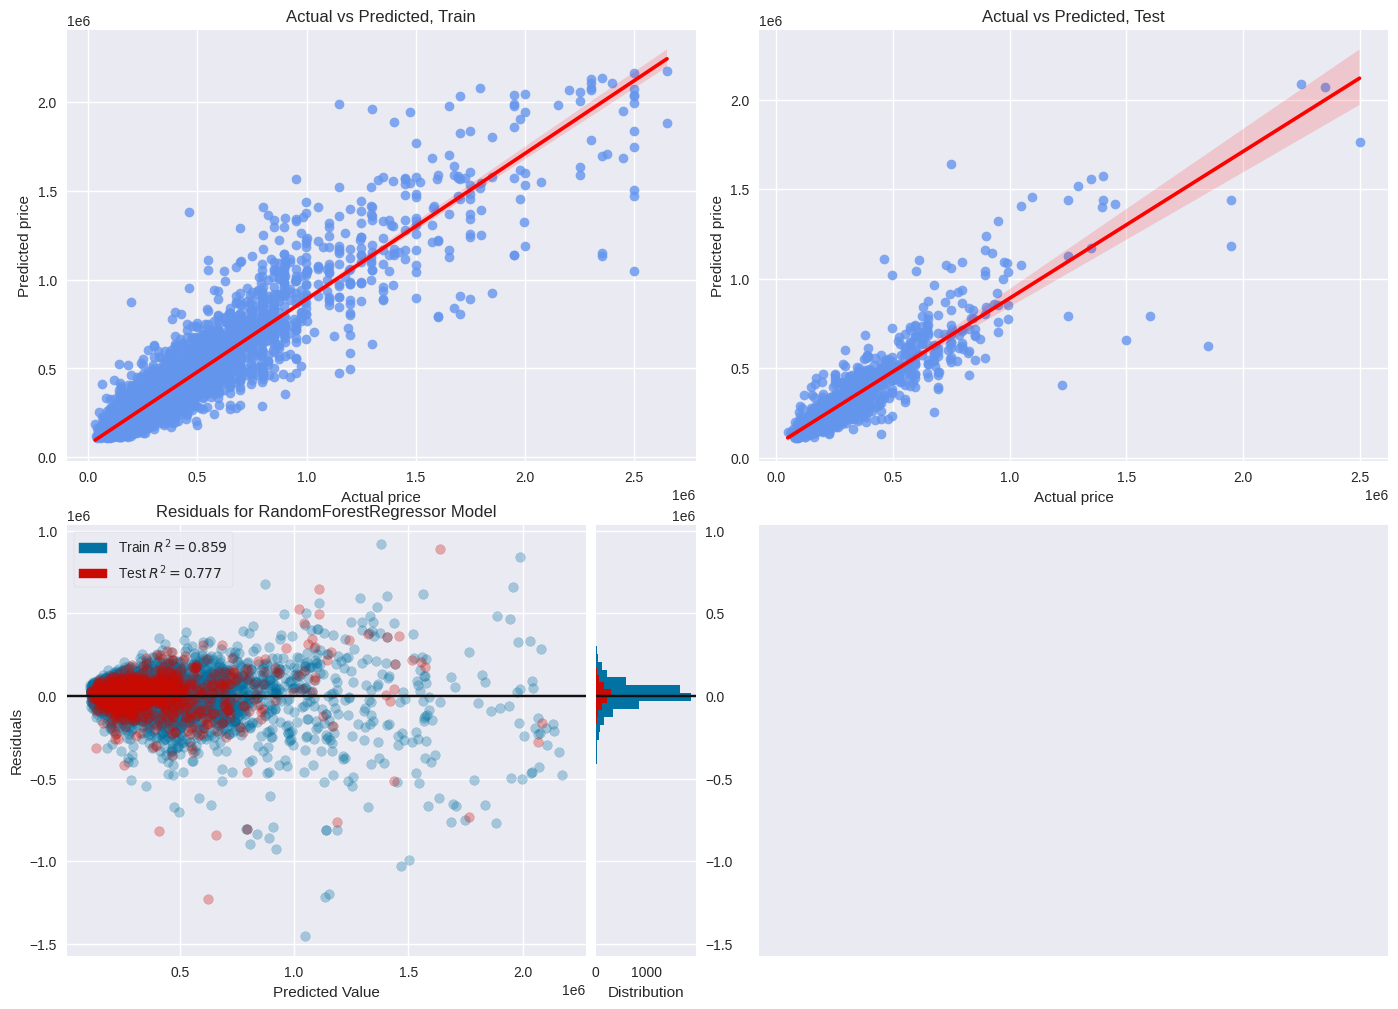

In [47]:
residuals(rfr, X_train, X_test, y_train, y_test)

- The tendency to understimate high values is a little smoother in the random forest.
- The model's performance is better predicting houses prices cheapper than a million euros than highers as well. 
- The voting regressor is still better than the random forest.

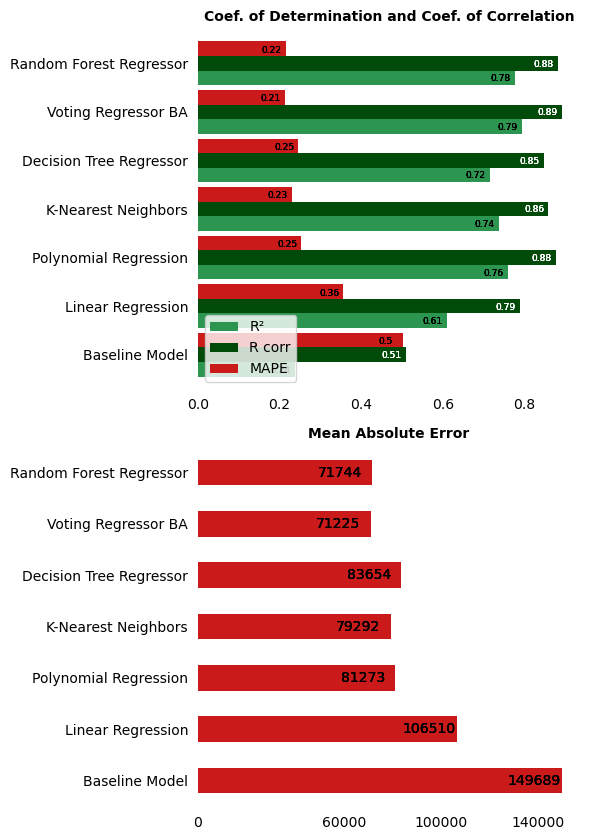

In [48]:
plot_metrics(metrics_to_plot)

## Extreme Gradient Boosting

The next code will give us the RMSE in the traiing set and in the test set 300 times, adding a new estimator every time. This will help us to choose the optimum number of estimators.

In [49]:
# MODIFICAR LA FUNCION PARA HACER ESTO
num_pipe = Pipeline([
            ('identity', PowerTransformer(method='yeo-johnson')),
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('imputer', SimpleImputer(strategy='median')),
            ])
cat_pipe = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories=[levels_place, levels_type_house])), 
        ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
        ])
preprocessor = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features),
        ])
pipe_estimator = Pipeline(steps=[
        ('preprocessor', preprocessor),
    #    ('regressor', regressor),
        ])


df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

X2 = pipe_estimator.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

xgb2 = XGBRegressor(n_estimators= 300, 
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.25)
   
xgb2.fit(X_train2, y_train2,
         eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.46875	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.43750	validation_1-rmse:373322.34375
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355672.06250	validation_1-rmse:313810.03125
[4]	validation_0-rmse:330057.06250	validation_1-rmse:289391.84375
[5]	validation_0-rmse:306698.06250	validation_1-rmse:267665.34375
[6]	validation_0-rmse:286240.09375	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268081.65625	validation_1-rmse:231536.37500
[8]	validation_0-rmse:251999.42188	validation_1-rmse:216863.78125
[9]	validation_0-rmse:238583.01562	validation_1-rmse:205219.40625
[10]	validation_0-rmse:226892.06250	validation_1-rmse:194319.60938
[11]	validation_0-rmse:216022.96875	validation_1-rmse:184938.79688
[12]	validation_0-rmse:207429.70312	validation_1-rmse:177333.15625
[13]	validation_0-rmse:198748.17188	validation_1-rmse:170024.84375
[14]	validation_0-rmse:191730.01562	validation_1-rmse:163887.79688
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

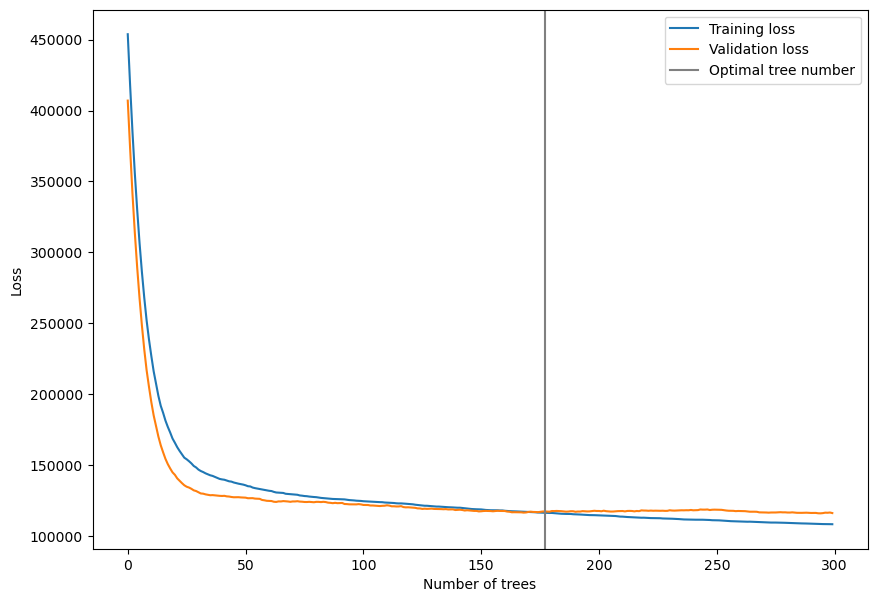

In [50]:
results = xgb2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(177, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

Once we know the optimum number of estimators we can obtain the metrics of our model. After a few iterations I realise that a `max_depth` of 3 helps us reduce overfitting.

In [51]:
xgb_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=XGBRegressor(
                                               n_estimators= 177, #150
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.30),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8007998479858557
r2 std: 0.03239256807883309 

MAE mean: -82490.53298346755
MAE std: 4127.423753613232 

MAPE mean: -0.23809956113906186
MAPE std: 0.009681614938300402 

RMSE mean: -134634.13733495708
RMSE std: 11578.911978121352 



### Overfitting Analysis

In [52]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['XGB'] = metrics

Performance on the training set:
 ----------
R²: 0.8571546668881757
MAE: 75164.74899996996
MAPE: 0.22592804708774575
RMSE: 114913.41844063411
R (corr): 0.9263692768800885

Performance on the test set:
 ----------
R²: 0.783143690257885
MAE: 73419.38819334166
MAPE: 0.22360425117494145
RMSE: 118756.99851407601
R (corr): 0.8861866720330773



### Residuals Diagnostic

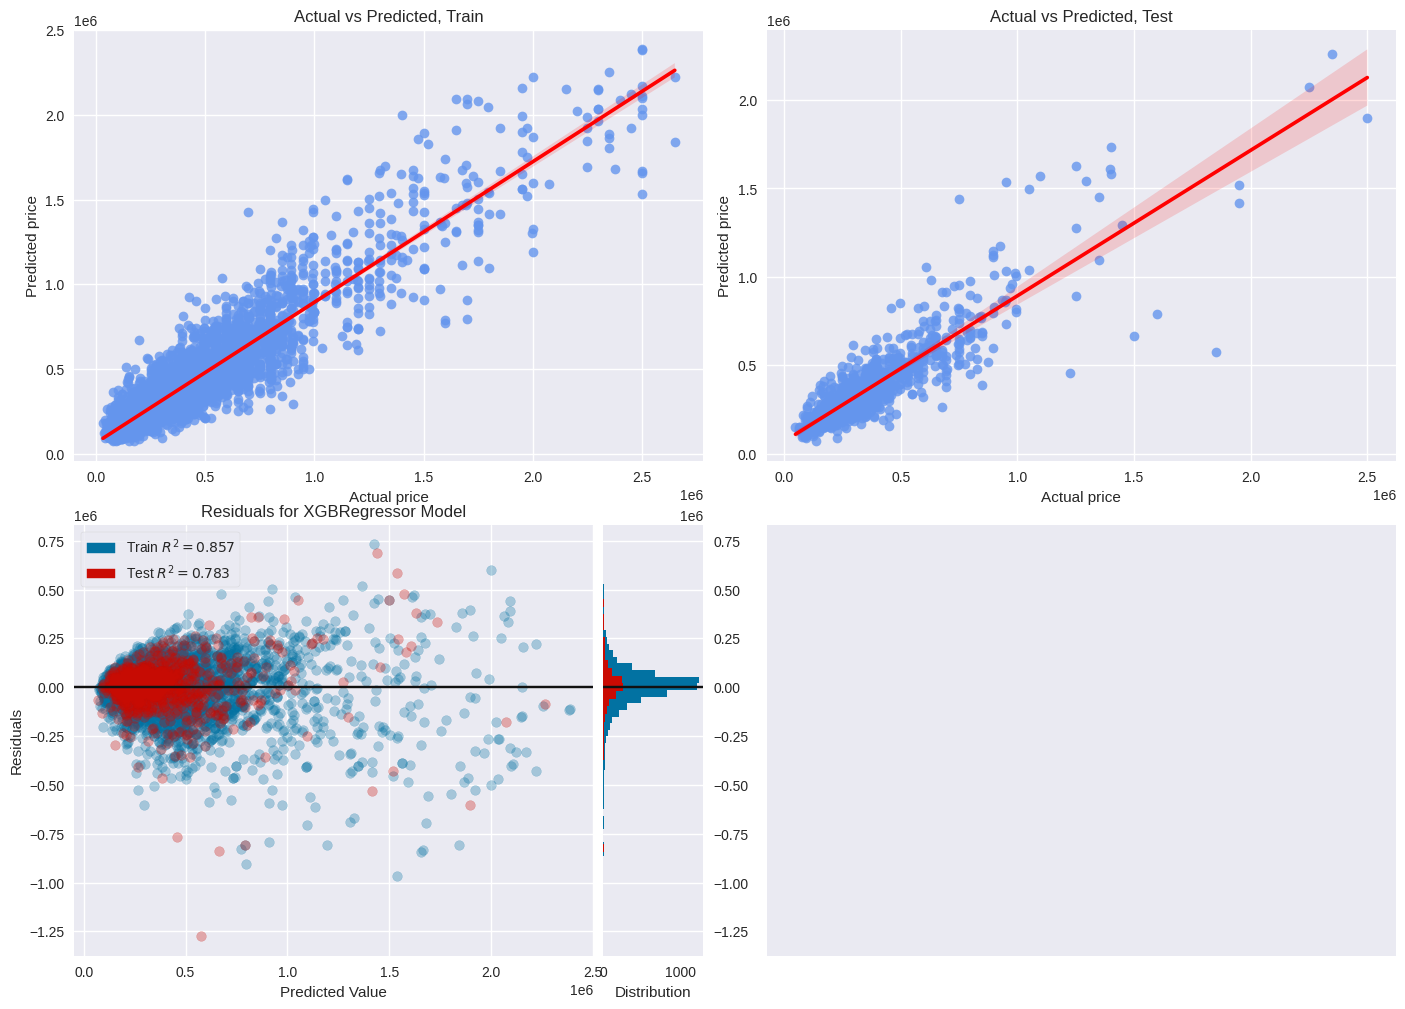

In [53]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

- The XGBRegressor appears to be a little bit better than the Random Forest.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.
- Both XGBRegressor and Voting Regressor with Basic Algorithms.

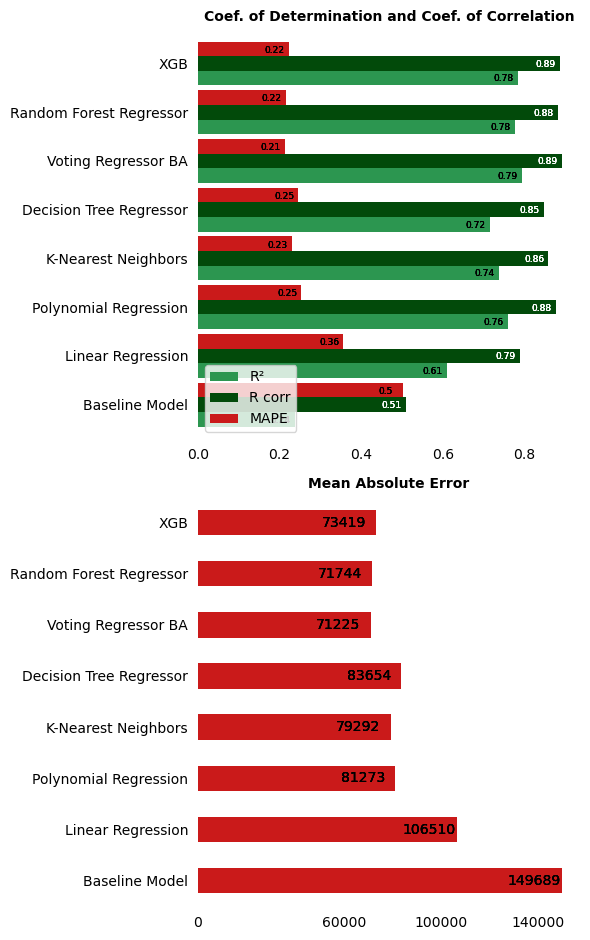

In [54]:
plot_metrics(metrics_to_plot)

## Voting Regressor with Ensemble Methods

Now let's see some combinations of voting regressors to see their performance.

The voting regressor that is performing better is the second, made up of:
- Voting Regressor Basic Algorithms
- Random Forest
- Extreme Gradient Boosting

So we will focus on it before try all voting regressors.

### Voting Regressor 1: poly + rfr + xgb

In [55]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Polynomial Regression': 0.7594927075514359, 'Random Forest Regressor': 0.777221489668346, 'XGB': 0.783143690257885}


In [56]:
polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7625036328416082
MAE mean: -92172.58797101252
----------
Random Forest Regressor
r2 mean: 0.7969791833158122
MAE mean: -80133.79402639378
----------
XGBoost
r2 mean: 0.7977052834802429
MAE mean: -83665.78445828285
----------
Voting Regressor
r2 mean: 0.8089831614459643
MAE mean: -79419.47870778426
----------


In [57]:
voting_regressor1.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor1.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor1.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8570241914958805
MAE: 71047.22108674196
MAPE: 0.20644791621182657
RMSE: 114965.88760724319
R (corr): 0.9269472823228572

Performance on the test set:
 ----------
R²: 0.7998798004683711
MAE: 69906.40011377283
MAPE: 0.2127899131724121
RMSE: 114082.39885899345
R (corr): 0.8953162193334666



(0.7998798004683711, 69906.40011377283, 0.8953162193334666, 0.2127899131724121)

### Voting Regressor 2: voting_regressor_BA + rfr + xgb 

In [58]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7946238858783001, 'Random Forest Regressor': 0.777221489668346, 'XGB': 0.783143690257885}


In [59]:
# voting_regressor_BA = voting_regressor_BA
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7891714699200817
MAE mean: -82264.52162741704
----------
Random Forest Regressor
r2 mean: 0.7969791833158122
MAE mean: -80133.79402639378
----------
XGBoost
r2 mean: 0.7977052834802429
MAE mean: -83665.78445828285
----------
Voting Regressor
r2 mean: 0.808618808166513
MAE mean: -78829.08443336822
----------


In [60]:
voting_regressor2.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor2.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor2.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor 2'] = metrics

Performance on the training set:
 ----------
R²: 0.8616473649474335
MAE: 68986.0072934578
MAPE: 0.20127775648010465
RMSE: 113091.88260396247
R (corr): 0.9299125385698945

Performance on the test set:
 ----------
R²: 0.7990985078588349
MAE: 69124.4518510853
MAPE: 0.20985325622085998
RMSE: 114304.87742324638
R (corr): 0.8942643035119325



### Voting Regressor 3: rfr + xgb

In [61]:
scores_dict = {}
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]


models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Random Forest Regressor': 0.777221489668346, 'XGB': 0.783143690257885}


In [62]:
# polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.7969791833158122
MAE mean: -80133.79402639378
----------
XGBoost
r2 mean: 0.7977052834802429
MAE mean: -83665.78445828285
----------
Voting Regressor
r2 mean: 0.8070583117486332
MAE mean: -79836.73390829701
----------


In [63]:
voting_regressor3.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor3.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor3.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8658856395454643
MAE: 69569.68697582888
MAPE: 0.20728834598166773
RMSE: 111346.18910417163
R (corr): 0.9317040879908156

Performance on the test set:
 ----------
R²: 0.7895594174044407
MAE: 70644.90169783977
MAPE: 0.21511168832164848
RMSE: 116987.08746180392
R (corr): 0.8894730860398149



(0.7895594174044407,
 70644.90169783977,
 0.8894730860398149,
 0.21511168832164848)

### Voting Regressor 4: voting_regressor_BA + rfr

In [64]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]

models_weigth_list = get_weigts(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7946238858783001, 'Random Forest Regressor': 0.777221489668346}


In [65]:
voting_regressor4 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr)], 
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr,
               'Voting Regressor4': voting_regressor4}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7891714699200817
MAE mean: -82264.52162741704
----------
Random Forest Regressor
r2 mean: 0.7969791833158122
MAE mean: -80133.79402639378
----------
Voting Regressor4
r2 mean: 0.8027380761525208
MAE mean: -78907.61971484777
----------


In [66]:
voting_regressor4.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor4.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor4.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8544368805934213
MAE: 67907.67545425215
MAPE: 0.1946279643801822
RMSE: 116001.44338256148
R (corr): 0.9260929096448065

Performance on the test set:
 ----------
R²: 0.7970192916968131
MAE: 69119.13289277744
MAPE: 0.2086097496766765
RMSE: 114894.85011186861
R (corr): 0.8930560087105781



(0.7970192916968131, 69119.13289277744, 0.8930560087105781, 0.2086097496766765)

### Residuals Diagnostic Voting Regressor 2: 

Let's get the diagnostic for the second voting regressor.

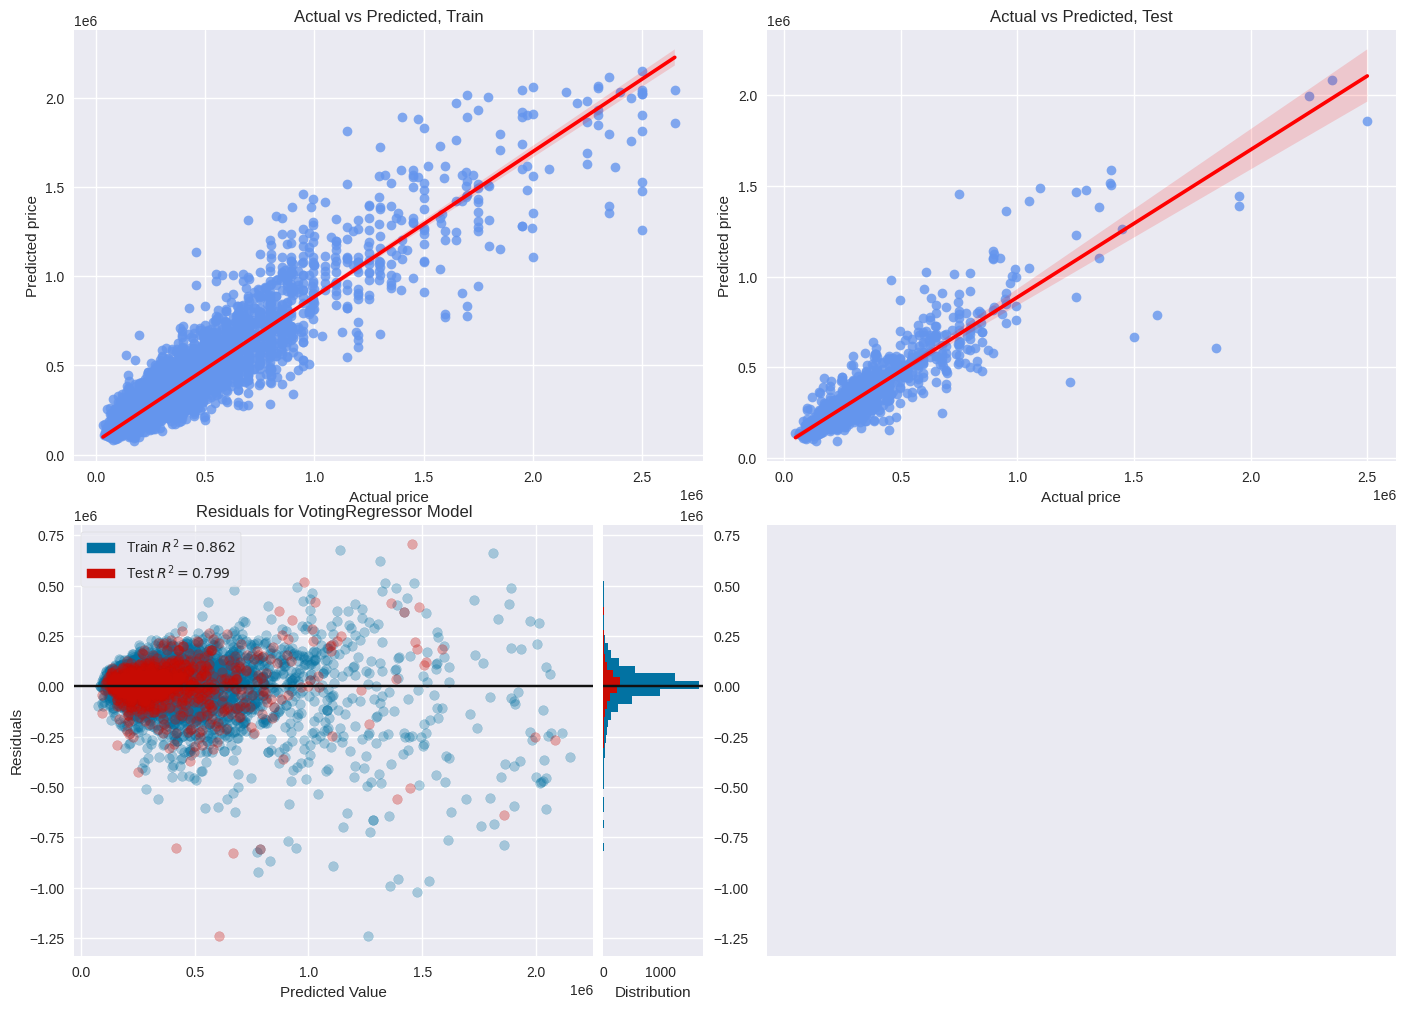

In [67]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

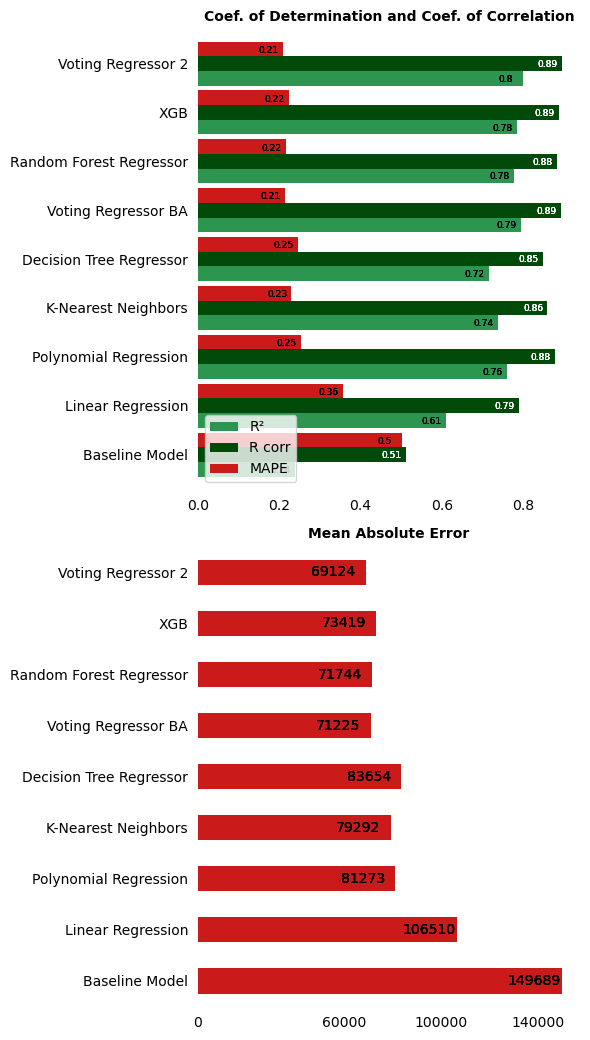

In [68]:
plot_metrics(metrics_to_plot)

## Stacking

To finish let's train a Stacking model. It will be made up the Voting Regressor with Basic Algorithms and the Extreme Gradient Boosting.

- Regression Meta-Model: Linear Reagression

In [69]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
 #   level0.append(('voting_regressor_BA', voting_regressor_BA))
    level0.append(('poly', polyr))
    level0.append(('rfr', rfr))
    level0.append(('xgb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [70]:
models_dict = {
#    'Voting Regressor BA': voting_regressor_BA, 
    'Polynomial Regression': polyr,
    'Random Forest Regressor': rfr, 
    'XGBoost': xgb_pipe_estimator,
    'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=6, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7625036328416082
MAE mean: -92172.58797101252
----------
Random Forest Regressor
r2 mean: 0.7969791833158122
MAE mean: -80133.79402639378
----------
XGBoost
r2 mean: 0.7977052834802429
MAE mean: -83665.78445828285
----------
Stacking
r2 mean: 0.808572039050536
MAE mean: -79701.93514167961
----------


### Overfitting Analysis

In [71]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Stacking Model'] = metrics

Performance on the training set:
 ----------
R²: 0.8668807110431673
MAE: 70109.77739759107
MAPE: 0.2064605188952545
RMSE: 110932.34936997975
R (corr): 0.9313721231019216

Performance on the test set:
 ----------
R²: 0.7878754017402859
MAE: 70940.05947975414
MAPE: 0.2128083029060901
RMSE: 117454.23957527494
R (corr): 0.8895846153004004



### Residuals Diagnostic

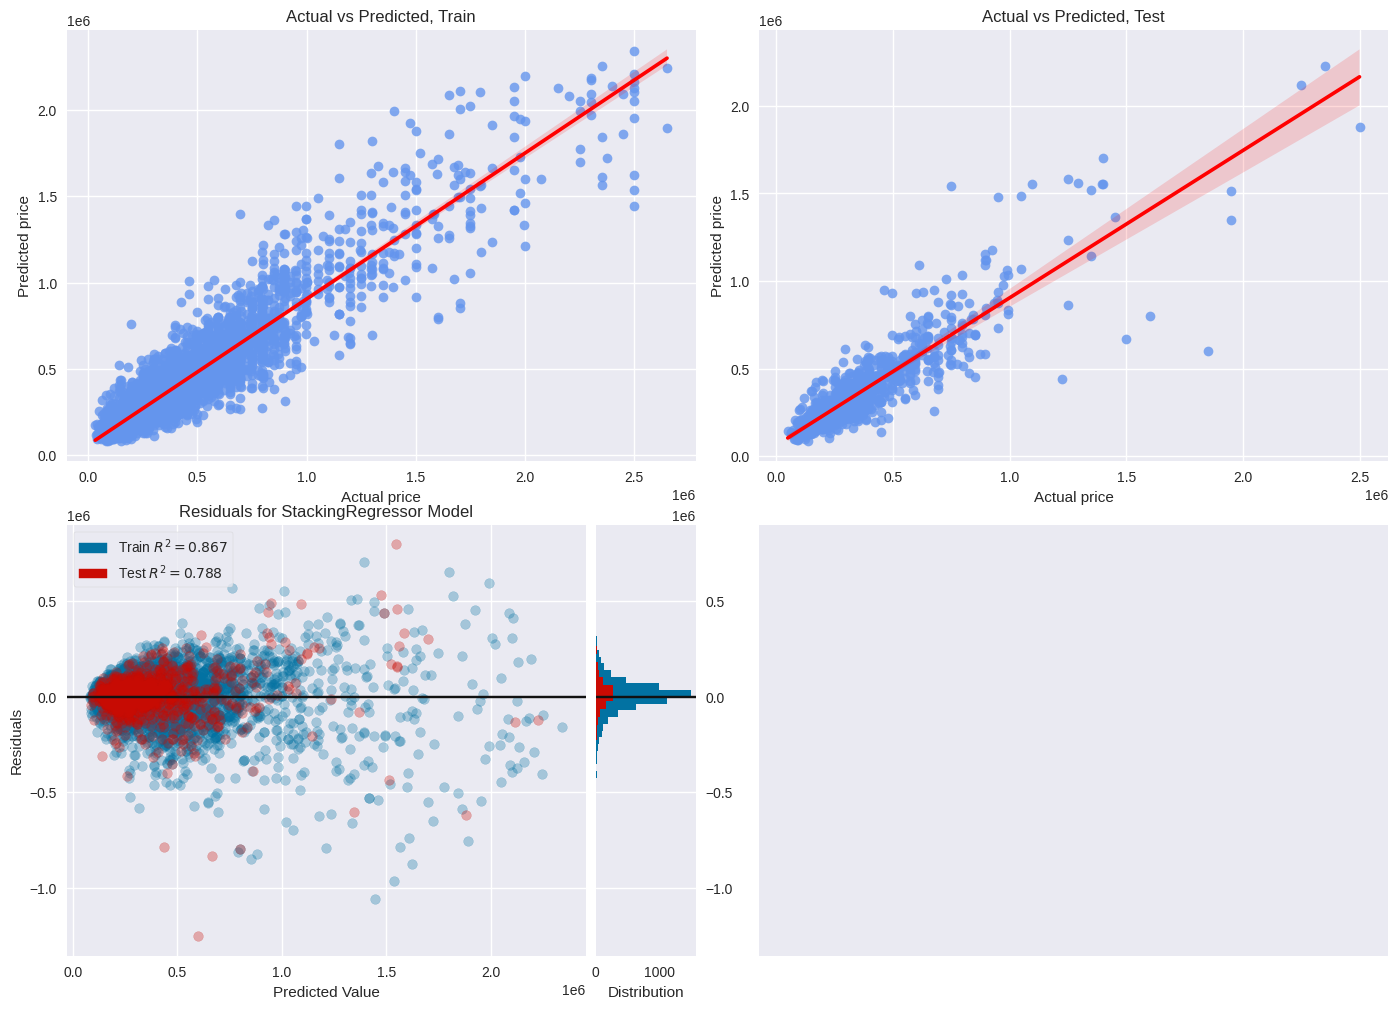

In [72]:
residuals(stacking, X_train, X_test, y_train, y_test)

- We have got some good performance in exchange of supporting more complexity.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.

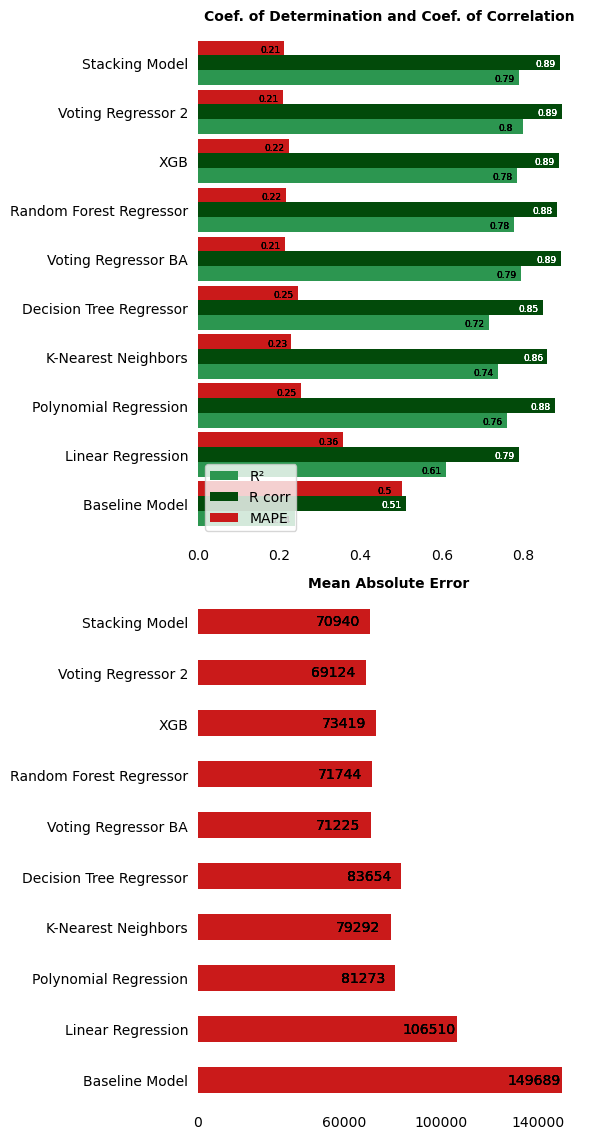

In [73]:
plot_metrics(metrics_to_plot)

# Conclusions and Model Selection

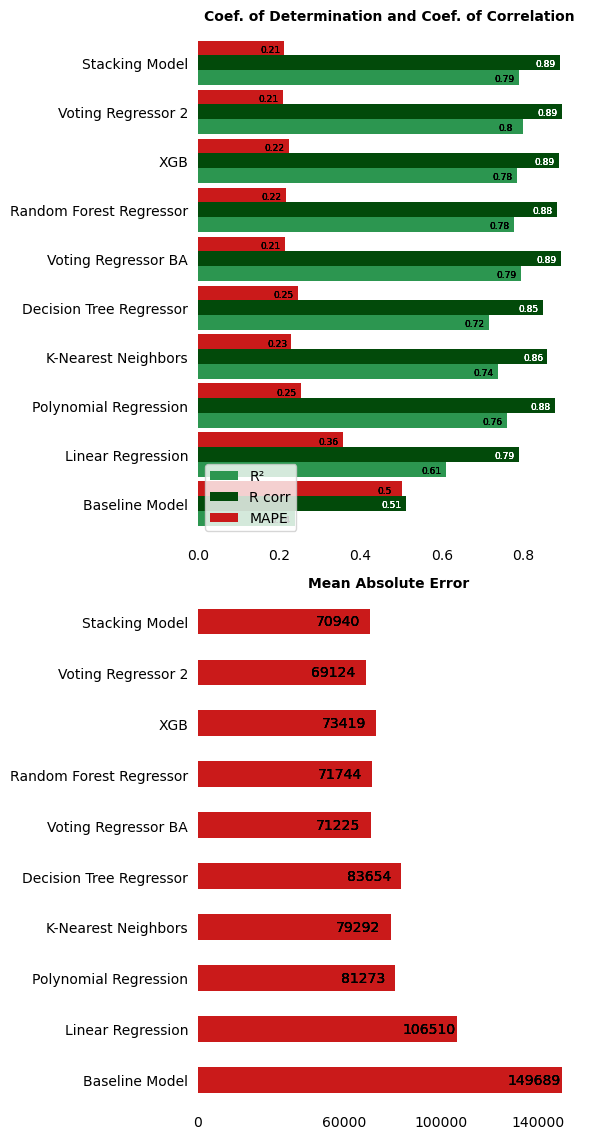

In [74]:
plot_metrics(metrics_to_plot=metrics_to_plot)

metrics_to_plotuce some conclusions from the work done in this notebooks.

- The best models obtain an r2 around 0.8 so those models are able to explain an 80% of the variability in prices. In Mean Absolute Error terms this is an error of 69,700€ aproximately when we try its performance in test set. This is not a super good score but it is not very bad as well taking into account the low number of features we are worked with.

- As we were increasing the complexity of the models the performance went up but the improvement wasn't to high so we will need to take a conciencious decision about what model we will use to predict the haouses' prices.

- Most of models tend to understimate houses prices which actual prices are over a million euros. Despite most houses are in the range price under a million this is still worrying. Our models are able to learn the relationship between preditor variables and the response variable better when the actual price of the house is under a million. That could be due to a lack of samples of expensive houses or due to a lack of predictors that can explain better the relationship with the price when it is too much high. Some predictors that perhaps explain that expensive prices could be the house year of construction, the anual income of residents in areas with expensive prices, etc. Also it may be possible that there is no predictors that explain those prices well which would mean that those expensive prices are absolutely disproportionate. 

- Another important aspect is the type of error that is less dangerous. Our model will be used to find potential investment opportunities which means that if the model understimates a house price that house would be less interesting to us as investemnt opportunity, discouraging us to invest money in that operation. That means that we would not win money but we would not loss it either. However, if the model tends to overstimate the price of a house it would be encouraging us to invest in that house so we could buy an asset which value is lower than its price. That means that we could loss money. So we can conclude that a model that tends to understimate asset prices is less dangerous to us that one that tends to overstimate them.

- Some future steps to improve our capability to predict houses prices are the following:
    - Obtain more information from the current variables we have. We could cluster the data or try to combine a few variables to get others with more predicting power.
    - Obtain more information from the current variables we have and other information we don't have as demographic data, income level per capita per area or city, distance from houses to diferent points of interest (schools, museums, universities, public transport, etc), weather data, etc.
    - Also we could try to develop different models for houses with prices under or over a million euros to figure out if it can perform better.
    - Finally we could try deep learning techniques to figure out the performance.
    
   
By the moment we will use the stacking model with a level 0 made up of a voting regressor with basic algorithms and an extreme gradient boosting and a linear regression as meta-model.

# Save Stacking Model

Before saving the winner model we will fit it to all the data instead only the training set. 

In [75]:
# Split data in predictors and target
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 8)
y: (7344,)


In [76]:
# Get the stacking model we created earlier
houses_prices_stacking_model = get_stacking()
# Fit the model to all the data
houses_prices_stacking_model.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('poly',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 Pipeline(steps=[('power_transformer',
                                                                                                  PowerTransformer()),
                                                                                                 ('poly',
                                                                                                  PolynomialFeatures(degree=4,
                                                                                                                     include_bias=False)),
                                                                                    

In [77]:
joblib.dump(houses_prices_stacking_model, 'models/houses_prices_stacking_model.plk')

['models/houses_prices_stacking_model.plk']

In [78]:
model = joblib.load('models/houses_prices_stacking_model.plk')
# model

# Prepare Data for Plotly Dash 

Now we have a trained model that we can use to predict prices. Here we will be using the data the model was trained with as is the data we have, but the model is useful to predict current unseen data from the real market. 

In [79]:
y_pred = model.predict(X)
# We convert y_pred to a list to avoid a problem with nan values
data['predicted_price'] = list(y_pred) 
# The residual is what will tell us whether the asset is a potential opportunity
data['residual'] = data.predicted_price - data.price
data['res_percentage'] = data.residual / data.price

As we are calculating the residuals extracting the  actual price from the predicted one, if the residual is a positive number it means that the predicted price is higher than the actual one so the asset could be an investment opportunity. 

We can see different examples of how the final DataFrame is running the cell below.

In [80]:
data.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,place,cluster,predicted_price,residual,res_percentage
4202,350000.0,193,53.763793,-7.837343,4,3,house,NaN,1,274100.506085,-75899.493915,-0.216856


After running the cell above several times I have realised that I should research more in depth the resulting DataFrame to try to figure out why some houses are better predicted and why others are not.

In [81]:
data.to_csv('data/data_predicted.csv', sep=',', index=False)